In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow import keras 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

In [ ]:
%cd /content/drive/My Drive/Kaggle/

In [ ]:
!kaggle competitions download -c digit-recognizer

In [ ]:
!unzip \*.zip  && rm *.zip

In [3]:
train = pd.read_csv('/content/drive/My Drive/Kaggle/train.csv')
test = pd.read_csv('/content/drive/My Drive/Kaggle/test.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

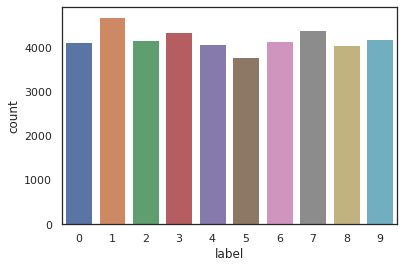

In [4]:
Y_train = train['label']

X_train = train.drop(labels=["label"], axis= 1)

g = sns.countplot(Y_train)
Y_train.value_counts()

Checking for missing values and Normalization


In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
X_train = X_train /255.0
test = test / 255.0

**Reshaping** and label encoding

In [7]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [8]:
Y_train = to_categorical(Y_train, num_classes = 10)

**Splitting into training and validation set**

In [24]:
random_seed = 10
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

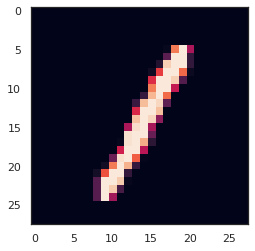

In [25]:
g = plt.imshow(X_train[0][:,:,0])

**Creating my CNN model**

In [26]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [27]:
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [32]:
model.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [33]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

DATA AUGMENTATION AND TRAINING THE NETWORK

In [34]:
epochs = 19
batch_size = 86
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False, 
        vertical_flip=False) 


datagen.fit(X_train)

In [36]:
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[annealer])

Epoch 1/19
356/356 - 200s - loss: 0.2117 - accuracy: 0.9346 - val_loss: 0.0652 - val_accuracy: 0.9803
Epoch 2/19
356/356 - 199s - loss: 0.1242 - accuracy: 0.9633 - val_loss: 0.0487 - val_accuracy: 0.9853
Epoch 3/19
356/356 - 199s - loss: 0.0923 - accuracy: 0.9730 - val_loss: 0.0390 - val_accuracy: 0.9874
Epoch 4/19
356/356 - 199s - loss: 0.0966 - accuracy: 0.9720 - val_loss: 0.0361 - val_accuracy: 0.9885
Epoch 5/19
356/356 - 200s - loss: 0.0735 - accuracy: 0.9781 - val_loss: 0.0292 - val_accuracy: 0.9906
Epoch 6/19
356/356 - 199s - loss: 0.0608 - accuracy: 0.9818 - val_loss: 0.0300 - val_accuracy: 0.9900
Epoch 7/19
356/356 - 199s - loss: 0.0565 - accuracy: 0.9833 - val_loss: 0.0305 - val_accuracy: 0.9915
Epoch 8/19
356/356 - 204s - loss: 0.0514 - accuracy: 0.9846 - val_loss: 0.0310 - val_accuracy: 0.9912
Epoch 9/19
356/356 - 199s - loss: 0.0496 - accuracy: 0.9855 - val_loss: 0.0264 - val_accuracy: 0.9924
Epoch 10/19
356/356 - 200s - loss: 0.0519 - accuracy: 0.9843 - val_loss: 0.0272 - 

In [37]:
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [38]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("My_first_project1.csv",index=False)

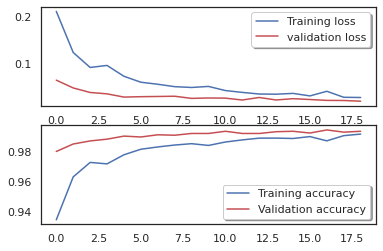

In [42]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

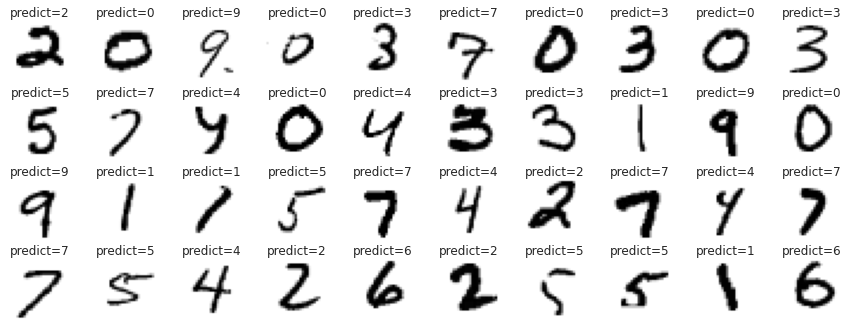

In [45]:
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()